# CE49X – Lab 5: Bias / Variance Tradeoff using the Air Quality Dataset

**Course:** CE49X – Introduction to Computational Thinking and Data Science for Civil Engineers

**Instructor:** Dr. Eyuphan Koç

**Semester:** Fall 2025

## Student Information

* **Name:** Hakan ARMAN

* **Student Number:** 2021403228

## 1. Introduction & Objectives

The goal of this lab is to explore the **bias–variance tradeoff**, a fundamental concept in machine learning. We will use a real-world dataset, the [UCI Air Quality Dataset](https://archive.ics.uci.edu/dataset/360/air+quality), to see how model performance changes as its complexity increases.

By the end of this lab, we will:

* Implement and compare **Linear Regression** and **Polynomial Regression** models.

* Visualize how **training error** and **testing error** change with model complexity.

* Identify and interpret the phenomena of **underfitting** (high bias) and **overfitting** (high variance).

We do the necessary imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import numpy as np
import time
from sklearn.model_selection import cross_val_score

ImportError: cannot import name 'Index' from 'pandas.core.indexes.base' (C:\Users\Hakan\AppData\Local\Programs\Python\Python314\Lib\site-packages\pandas\core\indexes\base.py)

In [ ]:
# Define file path and columns (as stated in the lab desc.)
data_file = "AirQualityUCI.csv"
features = ['T', 'RH', 'AH']
target = 'CO(GT)'

--- Step 1: Load the Dataset ---

We need to specify the delimiter (sep=';') and the decimal separator (decimal=',') to obey the format of our data

In [ ]:
try:
    data = pd.read_csv(
        data_file,
        sep=';',
        decimal=',',
        na_values=-200
    )

    # 2. Select the required columns
    columns_to_use = features + [target]
    df_model = data[columns_to_use].copy()

    # 3. Handle missing values
    # The simplest way is to drop rows where *our selected columns* have NaNs
    original_count = len(df_model)
    df_model.dropna(subset=columns_to_use, inplace=True)
    cleaned_count = len(df_model)

    print(f"Original rows (all columns): {len(data)}")
    print(f"Rows after selecting columns: {original_count}")
    print(f"Rows after dropping missing values in {columns_to_use}: {cleaned_count}\n")

    # 4. Define features (X) and target (y)
    X = df_model[features]
    y = df_model[target]

    # 5. Split into training (70%) and testing (30%) sets
    # We use random_state=42 for reproducible results
    # 42 here is a seed for the randomness generated. It is a dig at the famous Hitchhiker's Guide
    # setting a set ensures we get the same result every run (deterministic-randomness)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    print("Completed data loading and manipulation.\n")
    print(f"Total clean samples: {len(X)}")
    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}\n")

    print("--- X_train head ---")
    print(X_train.head())
    print("\n--- y_train head ---")
    print(y_train.head())

except FileNotFoundError:
    print(f"Error: The file '{data_file}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

--- Step 2: Fit Models of Increasing Complexity ---

We assume X_train, X_test, y_train, y_test already exist.

In [ ]:
degrees = range(1, 11)
train_errors = []
test_errors = []

print("--- Starting Model Training Loop ---")
print(f"{'Degree':<8} | {'Train RMSE':<12} | {'Test RMSE':<12}")
print("-" * 36)

for degree in degrees:
    # 1. Create the model pipeline
    # This pipeline correctly handles the steps for us:
    #   a) Create polynomial features
    #   b) Scale the features (important for numerical stability)
    #   c) Fit the linear regression model

    model_pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ])

    # 2. Train the model
    model_pipeline.fit(X_train, y_train)

    # 3. Compute training error
    y_train_pred = model_pipeline.predict(X_train)
    # Use np.sqrt to get RMSE from MSE
    # I chose to use RMSE for this lab, as it is simpler to understand the interpretations with physical data
    # as you get to see exactly the difference
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_errors.append(train_rmse)

    # 4. Compute testing error
    y_test_pred = model_pipeline.predict(X_test)
    # Use np.sqrt to get RMSE from MSE
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_errors.append(test_rmse)

    # Print the results for this degree
    print(f"{degree:<8} | {train_rmse:<12.4f} | {test_rmse:<12.4f}")

print("--- Model training complete ---")
print("\nWe now have 'train_errors' and 'test_errors' lists ready for plotting.")

--- Step 3: Plot the Validation Curve ---

We assume 'degrees', 'train_errors', and 'test_errors' exist from Step 2.

In [ ]:
try:
    # 1. Find the optimal degree (lowest test error)
    min_test_error_index = np.argmin(test_errors)
    optimal_degree = degrees[min_test_error_index]
    min_test_error = test_errors[min_test_error_index]

    # 2. Create the plot
    plt.figure(figsize=(10, 6))  # Make the plot a bit larger

    # Plot the error curves
    plt.plot(degrees, train_errors, 'bo-', label='Training Error')
    plt.plot(degrees, test_errors, 'ro-', label='Testing Error')

    # Mark the optimal point with a vertical line
    plt.axvline(x=optimal_degree, color='gray', linestyle='--',
                label=f'Optimal (Degree {optimal_degree})')

    # 3. Add labels and title
    plt.xlabel('Model Complexity (Polynomial Degree)')
    # Note: We use RMSE because it's more interpretable (as discussed).
    # The lab's example uses MSE, but the shape is identical.
    plt.ylabel('Root Mean Squared Error (RMSE)')
    plt.title('Bias–Variance Tradeoff')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(degrees)  # Ensure all degrees (1-10) are shown on the x-axis

    # 4. Label the regions (as requested in lab5.md)
    # Get current plot limits to place text
    y_min, y_max = plt.ylim()
    text_y_pos = y_min + (y_max - y_min) * 0.8  # Place text 80% up the y-axis

    # Underfitting Region
    plt.text(2, text_y_pos, 'Underfitting\n(High Bias)',
             horizontalalignment='center', fontsize=11, color='blue')

    # Overfitting Region
    plt.text(8, text_y_pos, 'Overfitting\n(High Variance)',
             horizontalalignment='center', fontsize=11, color='red')

    # Annotate the optimal point
    plt.annotate(
        f'Sweet Spot\nRMSE: {min_test_error:.4f}',
        xy=(optimal_degree, min_test_error),
        xytext=(optimal_degree + 1.5, min_test_error + (y_max - y_min) * 0.1),
        arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
        horizontalalignment='center'
    )

    # 5. Save the figure
    plt.savefig('bias_variance_curve.png', bbox_inches='tight', dpi=150)

    print("Plot generated and saved as 'bias_variance_curve.png'")
    print(f"Based on the data, the optimal model was found at:")
    print(f"  - Polynomial Degree: {optimal_degree}")
    print(f"  - Minimum Testing RMSE: {min_test_error:.4f}")

except NameError:
    print("Error: 'degrees', 'train_errors', or 'test_errors' not found.")
    print("Please run Step 2 first to generate these variables.")
except Exception as e:
    print(f"An error occurred during plotting: {e}")

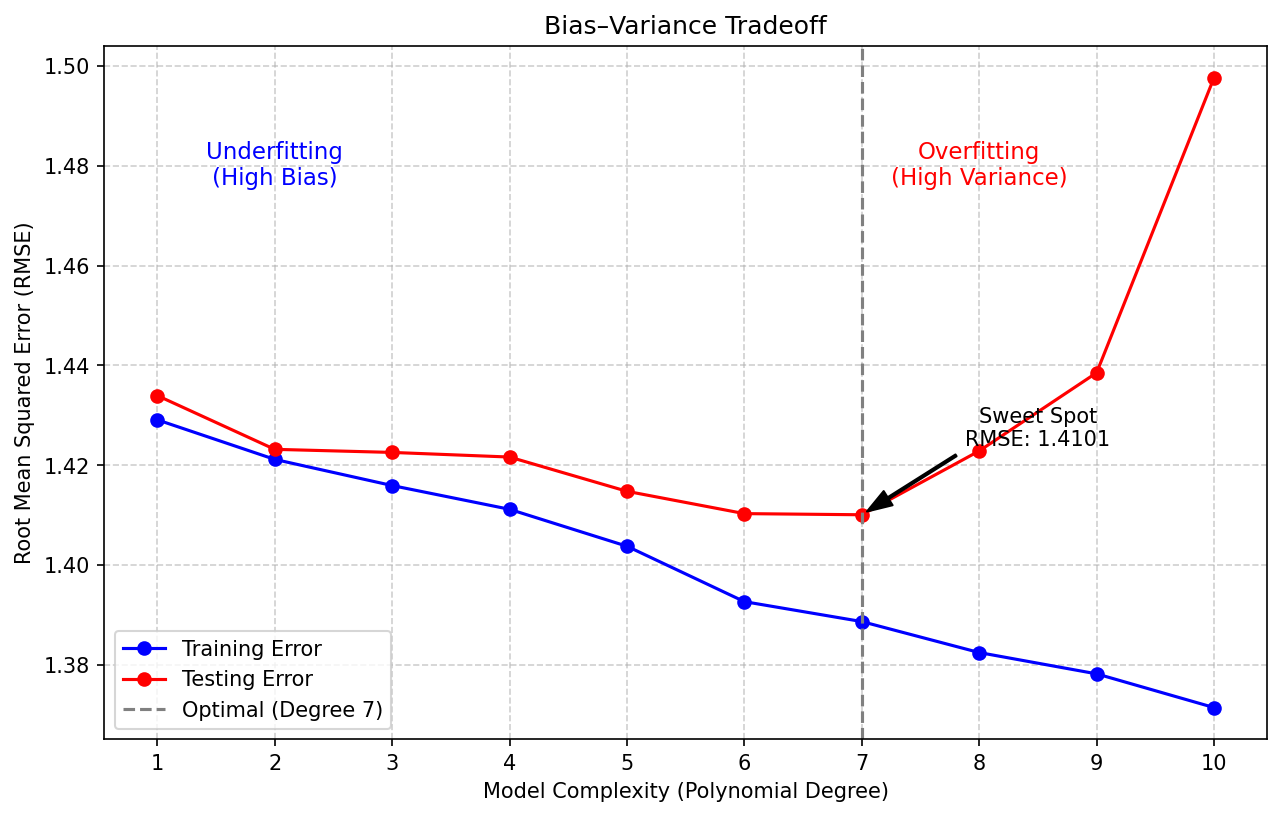

--- Bonus: Cross-Validation ---

We assess another testing apporach, namely, cross-validation (which is regareded as a safer alternative)

This is made with the "Pipeline" approach, for a simpler approach that agrees better with the labs findings, you can check the upcoming parts.

In [ ]:
# 1. Load the FULL clean dataset (no train/test split)
try:
    data_file = "AirQualityUCI.csv"
    features = ['T', 'RH', 'AH']
    target = 'CO(GT)'
    data = pd.read_csv(data_file, sep=';', decimal=',', na_values=-200)
    df_model = data[features + [target]].copy()
    df_model.dropna(subset=features + [target], inplace=True)

    # We use the *full* dataset for cross-validation, but divide it into sections.
    # In this case, we divide it into 10 section and use 1 of the sections as test data whilst training on the rest
    # The model does this and test all 10 sections, giving us better estimations.
    # This is done so we are not affected from the initial test data sampling bias as 30% is a large part of our set.
    # As discussed in the lecture
    X = df_model[features]
    y = df_model[target]

    print(f"Loaded full, clean dataset. Total samples: {len(y)}\n")

except Exception as e:
    print(f"Error loading data: {e}")
    # Create dummy data if file not found, to allow script to run
    X = pd.DataFrame(np.random.rand(100, 3), columns=features)
    y = pd.Series(np.random.rand(100))

# 2. Run the cross-validation loop
degrees = range(1, 11)
cv_test_errors_mean = []
cv_test_errors_std = []

# Define the number of folds
N_FOLDS = 10

print(f"--- Starting {N_FOLDS}-Fold Cross-Validation ---")
print(f"{'Degree':<8} | {'Mean Test RMSE':<14} | {'Std Dev RMSE':<12} | {'Time (s)':<8}")
print("-" * 50)

for degree in degrees:
    start_time = time.time()

    # Create the same pipeline as before
    model_pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ])

    # 3. Use cross_val_score
    # We use 'neg_mean_squared_error' because cross_val_score
    # assumes "higher is better". We will flip the sign back.
    cv_scores_mse = cross_val_score(
        model_pipeline,
        X,  # Full X
        y,  # Full y
        cv=N_FOLDS,
        scoring='neg_mean_squared_error',
        n_jobs=-1  # Use all available CPU cores
    )

    # 4. Process the results
    # a) Flip the sign to get positive MSE
    cv_scores_mse_positive = -cv_scores_mse
    # b) Take the square root to get RMSE
    cv_scores_rmse = np.sqrt(cv_scores_mse_positive)

    # c) Get the mean and standard deviation of the RMSE across all 10 folds
    mean_rmse = np.mean(cv_scores_rmse)
    std_rmse = np.std(cv_scores_rmse)

    cv_test_errors_mean.append(mean_rmse)
    cv_test_errors_std.append(std_rmse)

    end_time = time.time()
    elapsed = end_time - start_time

    print(f"{degree:<8} | {mean_rmse:<14.4f} | {std_rmse:<12.4f} | {elapsed:<8.2f}")

print("--- Cross-validation complete ---")

# 5. Find the new optimal degree
optimal_cv_degree_index = np.argmin(cv_test_errors_mean)
optimal_cv_degree = degrees[optimal_cv_degree_index]
min_cv_rmse = cv_test_errors_mean[optimal_cv_degree_index]

print("\n--- CV Results ---")
print(f"Optimal Degree (from {N_FOLDS}-Fold CV): {optimal_cv_degree}")
print(f"Minimum Mean Test RMSE: {min_cv_rmse:.4f}")

# 6. Plot the CV results
plt.figure(figsize=(10, 6))
cv_errors = np.array(cv_test_errors_mean)
cv_std = np.array(cv_test_errors_std)

# Plot the mean error
plt.plot(degrees, cv_errors, 'go-', label='Mean CV Testing Error')

# Create the confidence interval band
plt.fill_between(
    degrees,
    cv_errors - cv_std,
    cv_errors + cv_std,
    color='green',
    alpha=0.2,
    label='+/- 1 Std Dev'
)

# Mark the optimal point
plt.axvline(x=optimal_cv_degree, color='gray', linestyle='--',
            label=f'Optimal (Degree {optimal_cv_degree})')

plt.xlabel('Model Complexity (Polynomial Degree)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title(f'Cross-Validation Results ({N_FOLDS} Folds)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(degrees)
plt.savefig('bias_variance_cv_curve.png', bbox_inches='tight', dpi=150)

print("\nPlot generated and saved as 'bias_variance_cv_curve.png'")

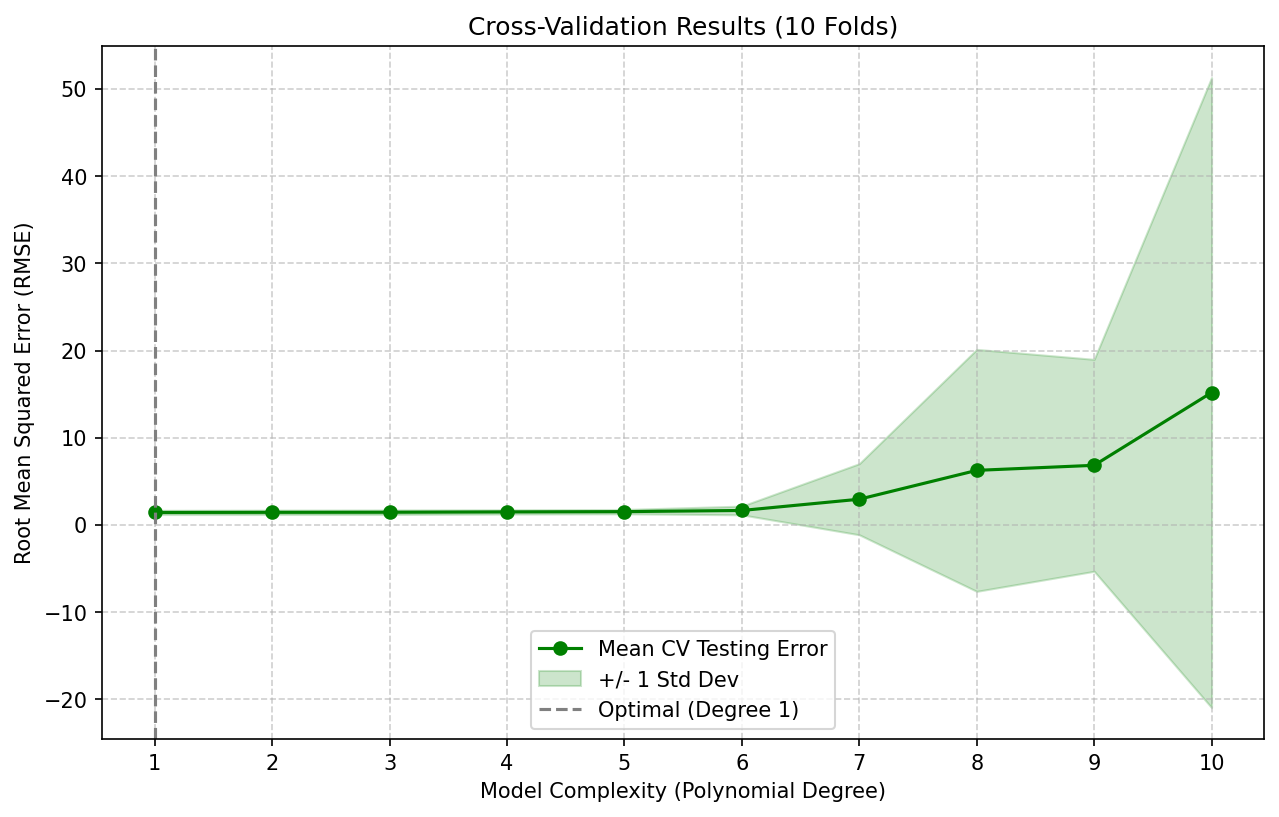

--- Another 10-Fold Cross-Validation + Comparison Plot (Using just the minimum RMSE, without stability penalty) ---

Yields a 6th degree solution as it explains the data better, however, with it is not selected when stability penalties are applied because a 6th degree solution is computationally expensive and thus, less reliable to use than a first 1st degree one.

When the scores are close like our tests, some approaches will choose the 1st degree one although it does not
output the best score. 

penalized = mean + std / optimal = np.argmin(penalized)

This is why higher degree models are called high variance, they simply have higher variance / std.

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=10, shuffle=True, random_state=42)

cv_errors_mean = []
cv_errors_std = []

print("\n--- Starting 10-Fold Cross-Validation ---")
print(f"{'Degree':<8} | {'Mean CV RMSE':<15} | {'Std Dev':<10}")
print("-" * 40)

for degree in degrees:
    model_pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ])

    # cross_val_score returns negative MSE → convert to RMSE
    neg_mse_scores = cross_val_score(
        model_pipeline, X, y,
        scoring='neg_mean_squared_error',
        cv=cv,
        n_jobs=-1
    )

    rmse_scores = np.sqrt(-neg_mse_scores)
    mean_rmse = rmse_scores.mean()
    std_rmse = rmse_scores.std()

    cv_errors_mean.append(mean_rmse)
    cv_errors_std.append(std_rmse)

    print(f"{degree:<8} | {mean_rmse:<15.4f} | {std_rmse:<10.4f}")

# --- Automatically select the optimal degree ---
optimal_index = np.argmin(cv_errors_mean)
optimal_degree = degrees[optimal_index]
min_rmse = cv_errors_mean[optimal_index]
std_at_optimal = cv_errors_std[optimal_index]

# --- Print the optimal result ---
print("\n--- Optimal Model from Cross-Validation ---")
print(f"Optimal polynomial degree: {optimal_degree}")
print(f"Minimum mean CV RMSE: {min_rmse:.4f}")
print(f"Standard deviation at this degree: {std_at_optimal:.4f}")

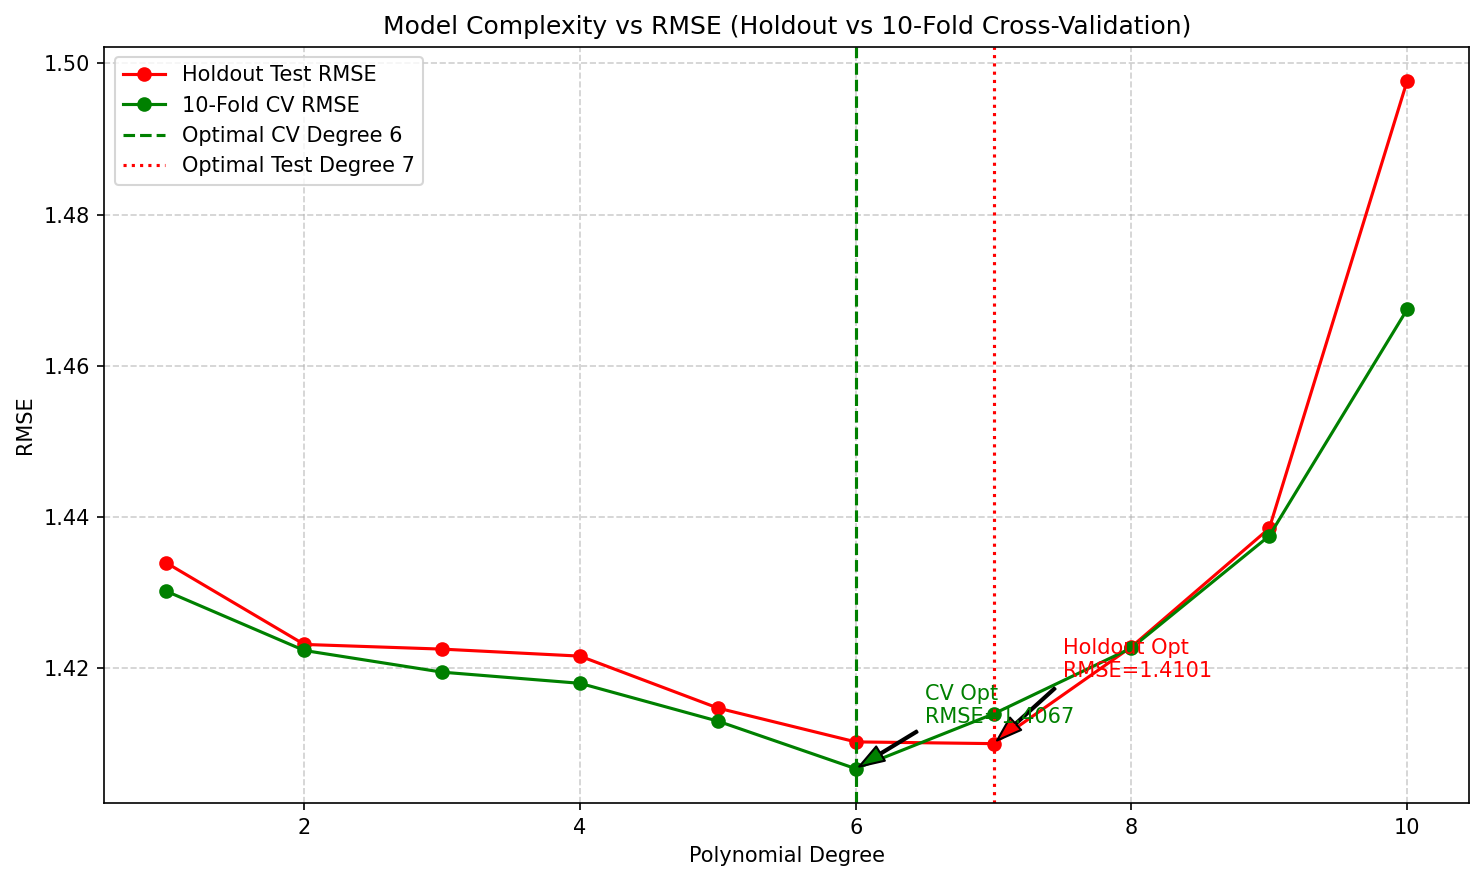

--- Code Snippet for Inspecting ALL Model Parameters ---

THIS PART IS NOT FOR THE LAB, BUT RATHER FOR MY ENJOYMENT.

I DID THIS SO I CAN OBSERVE THE PARAMETERS ETC. 

RUNNING THIS WOULD BE (SOMEWHAT) COMPUTATIONALLY EXPENSIVE (Not as much as the CV case though)

In [ ]:
print("\n" + "=" * 50)
print("START: Inspecting Parameters for All Models")
print("=" * 50 + "\n")

try:
    # This loop will train and print parameters for each degree
    for degree in degrees:  # 'degrees' should be range(1, 11)

        print(f"--- Model: Degree {degree} ---")

        # 1. Create the model pipeline
        model_pipeline = Pipeline([
            ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
            ('scaler', StandardScaler()),
            ('model', LinearRegression())
        ])

        # 2. Train the model on the full training set
        model_pipeline.fit(X_train, y_train)

        # 3. Get the parameters from the *final* step
        intercept = model_pipeline.named_steps['model'].intercept_
        coeffs = model_pipeline.named_steps['model'].coef_

        # 4. Get the feature names from the *poly* step
        poly_feature_names = model_pipeline.named_steps['poly'].get_feature_names_out(features)

        # 5. Print them
        print(f"Intercept (b): {intercept:.4f}")

        print("Coefficients (m):")
        for name, coeff in zip(poly_feature_names, coeffs):
            # We use <15 to give a bit more room for long names
            print(f"  - {name:<15}: {coeff:.4f}")

        print("-" * 50)  # Add a separator

except NameError as e:
    print(f"\nError: Could not find necessary variables (like X_train, y_train, features, or degrees).")
    print("Please make sure you have run Step 1 and 2 first.")
except Exception as e:
    print(f"\nAn error occurred: {e}")

# --- End of Snippet --- 

### Step 4 — Discussion
#### Answer the following in your report:
**Which polynomial degree gives the best generalization?**

In my test with 30% of data allocated to testing, a degree 7 polynomial proved the most effective. 

However, in my observations, the results were pretty close and sampling bias was a big problem for this data set, requiring use of preventive measures or different approaches such as cross validation. (which suggests a 1st degree model, however, I am not sure if I implemented it correctly)

I say so because whenever I used a different random seed, the results would change. (a seed of 42 resulted in degree 7 whilst 0 resulted in degree 6).

**Describe how the training and testing errors change as degree increases.**

As can be observed from the graph, with increasing complexity training error always decreases as the model learns to fit the training data provided exactly as it is, resulting in it "memorizing" the data set with very complex models. This is called overfitting or a high variance model. In addition, training errors are maximized in the start, where the model is too simple to accurately capture a relationship. This is called underfitting or a high bias model. We solve this by increasing model complexity.

A different trend is observed with testing errors. There is a sweet spot between simple and complex models where the testing errors are minimized. A good explanation for this is the memorization scenario mentioned above. Thus, it is important to fine tune our models to yield the minimum testing error, avoiding both very simple and very complex models. Thus, testing error is high at the start, then slowly gets smaller as it reaches a sweet-spot platue, afterwards it starts to rise possibly exceeding it is first value with the simplest of models.

**Explain how bias and variance manifest in this dataset.**

High Bias: This can be easily observed in the graph where simpler models (up to the 4th degree) output suboptimal RMSE values. This results from the relationship being more complex than the model assumes, thus, we need to bump up the complexity and use higher order models to fix.

High Variance: Tihs can be easily observed in the section of the graph labeled "overfitting". Using a unnecessarily complex model will result in the model memorizing the training data, thus, incorporate the noise within to its structure. This makes the model fail to capture the real relationship and produce mistakes 

**How might sensor noise or missing data affect the bias–variance tradeoff?**
Sensor Noise: If there was excessive noise in the CO(GT) readings, our "irreducible errors" (errors due to noise) would increase, stemming from the fact that we do not get to see the real relationship between the parameters in the dataset but rather observe a distorted state, making it harder for any model to perform well. This increased error would then get inputed to our parameters which results in pre-mature overfitting (mistaking the noise for a very complex relationship pattern).

Missing Data: If we were to imputate NaN values instead of straight on dropping them, we would have introduced a different kind of bias, where we force the model towards outputting the average value (especially so when there are a lot of missing CO(GT) values) or artifically distort data to yield noisy relationships.
